In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split,TensorDataset
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
import tarfile
import os

In [51]:
dataset_url = "http://files.fast.ai/data/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


In [52]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [53]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test', 'labels.txt']
['deer', 'cat', 'automobile', 'ship', 'dog', 'horse', 'truck', 'frog', 'bird', 'airplane']


## Dataset and Dataloader

In [54]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

Shape:  torch.Size([3, 32, 32])
lable:  0


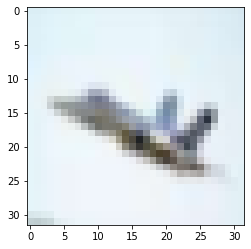

In [55]:
img, label = dataset[0]
print("Shape: ",img.shape)
print("lable: ",label)
plt.imshow(img.permute(1,2,0))

In [56]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [57]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [58]:
batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

## Visualising a batch of image

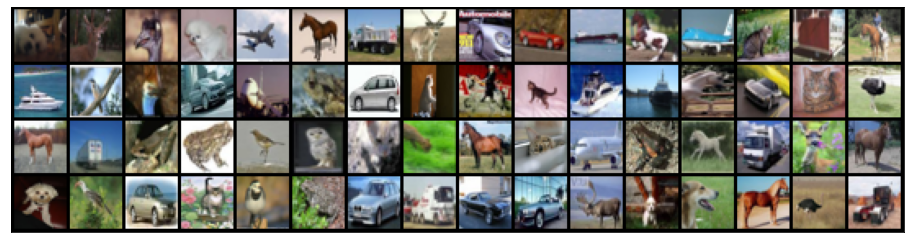

In [59]:
for images, labels in train_loader:
  fig, ax = plt.subplots(figsize=(16, 8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
  break

## Building the Model

In [60]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Cifar10(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 64*16*16

        nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 128*8*8

        nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 256*4*4

        nn.Flatten(),
        nn.Linear(256*4*4,512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,10)
        )
    
  def forward(self,xb):
    out = self.network(xb)
    return out

  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss':loss,'val_acc':acc}

  def validation_epoch_end(self,outputs):
    batch_loss = [out['val_loss'] for out in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [out['val_acc'] for out in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

  def epoch_end(self,epoch,result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))
  

In [61]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Cifar10_Updated(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 64*16*16

        nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 128*8*8

        nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2), #output : 256*4*4
        nn.AdaptiveAvgPool2d(1), ## to keep track of input size

        nn.Flatten(),
        nn.Linear(256,512),
        nn.ReLU(),
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,10)
        )
    
  def forward(self,xb):
    out = self.network(xb)
    return out

  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    images,labels = batch
    out = self(images)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'val_loss':loss,'val_acc':acc}

  def validation_epoch_end(self,outputs):
    batch_loss = [out['val_loss'] for out in outputs]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [out['val_acc'] for out in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}

  def epoch_end(self,epoch,result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))
  

## Training and evaluation 

In [62]:
@torch.no_grad()
def evaluate(model,val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

In [63]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

## Using GPU

In [64]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [65]:
device = get_default_device()
device

device(type='cuda')

In [66]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [67]:
model = to_device(Cifar10(), device)

## Training the model

In [68]:
history = fit(10, 0.001, model, train_loader, val_loader, opt_func = torch.optim.Adam)

Epoch [0], train_loss: 1.6642, val_loss: 1.3839, val_acc: 0.5042
Epoch [1], train_loss: 1.1706, val_loss: 1.0641, val_acc: 0.6112
Epoch [2], train_loss: 0.9133, val_loss: 0.9034, val_acc: 0.6839
Epoch [3], train_loss: 0.7323, val_loss: 0.8316, val_acc: 0.7184
Epoch [4], train_loss: 0.6062, val_loss: 0.7270, val_acc: 0.7557
Epoch [5], train_loss: 0.5099, val_loss: 0.7659, val_acc: 0.7431
Epoch [6], train_loss: 0.4210, val_loss: 0.7566, val_acc: 0.7684
Epoch [7], train_loss: 0.3393, val_loss: 0.8065, val_acc: 0.7674
Epoch [8], train_loss: 0.2721, val_loss: 0.8780, val_acc: 0.7603
Epoch [9], train_loss: 0.2280, val_loss: 0.9835, val_acc: 0.7482


In [69]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [70]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

## Ploting Train ans Test Loss

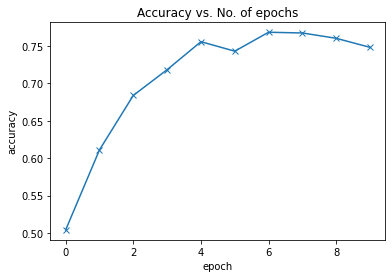

In [71]:
plot_accuracies(history)

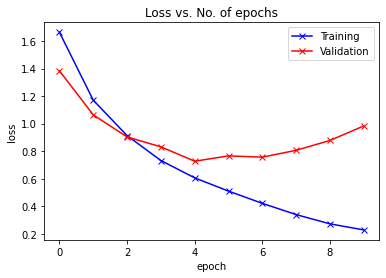

In [72]:
plot_losses(history)

## Evaluating on test data

In [76]:
os.listdir(data_dir)
test_dataset  = ImageFolder(root= data_dir+'/test',transform=ToTensor())

In [77]:
test_loader = DataLoader(test_dataset, batch_size, num_workers=4, pin_memory=True)

In [78]:
test_loader = DeviceDataLoader(test_loader, device)

In [79]:
evaluate(model,test_loader)

{'val_acc': 0.7489052414894104, 'val_loss': 0.9786142110824585}

## Fitting and Evaluating on updated model

In [80]:
model1 = to_device(Cifar10_Updated(),device)

In [82]:
history = fit(10, 0.001, model1, train_loader, val_loader, opt_func = torch.optim.Adam)

Epoch [0], train_loss: 1.9121, val_loss: 1.7002, val_acc: 0.3307
Epoch [1], train_loss: 1.4789, val_loss: 1.2503, val_acc: 0.5382
Epoch [2], train_loss: 1.1698, val_loss: 1.0529, val_acc: 0.6250
Epoch [3], train_loss: 0.9845, val_loss: 1.0104, val_acc: 0.6371
Epoch [4], train_loss: 0.8527, val_loss: 0.9053, val_acc: 0.6907
Epoch [5], train_loss: 0.7513, val_loss: 0.7756, val_acc: 0.7239
Epoch [6], train_loss: 0.6632, val_loss: 0.8429, val_acc: 0.7126
Epoch [7], train_loss: 0.5834, val_loss: 0.8094, val_acc: 0.7290
Epoch [8], train_loss: 0.5211, val_loss: 0.8016, val_acc: 0.7433
Epoch [9], train_loss: 0.4610, val_loss: 0.7241, val_acc: 0.7625


In [83]:
history += fit(5, 0.001, model1, train_loader, val_loader, opt_func = torch.optim.Adam)

Epoch [0], train_loss: 0.4107, val_loss: 0.7150, val_acc: 0.7712
Epoch [1], train_loss: 0.3570, val_loss: 0.7186, val_acc: 0.7725
Epoch [2], train_loss: 0.3165, val_loss: 0.7190, val_acc: 0.7822
Epoch [3], train_loss: 0.2812, val_loss: 0.7830, val_acc: 0.7682
Epoch [4], train_loss: 0.2552, val_loss: 0.7334, val_acc: 0.7909


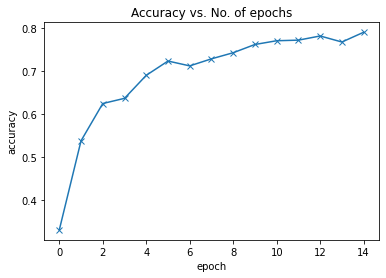

In [84]:
plot_accuracies(history)

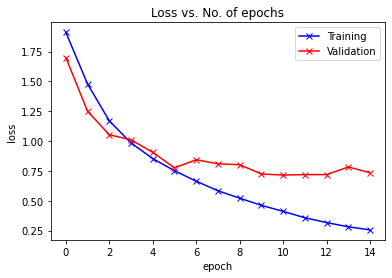

In [85]:
plot_losses(history)

In [86]:
evaluate(model1,test_loader)

{'val_acc': 0.7915008068084717, 'val_loss': 0.733349084854126}